In [22]:
import warnings

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import seaborn as sns

from sklearn.pipeline import Pipeline

from preprocess_sunshine import sunshine_transformer
from preprocess_raintomorrow import raintomorrow_transformer
from preprocess_date import preprocess_date_transformer
from preprocess_temp import preprocess_temp
from preprocess_rainfall_raintoday import rainfall_raintoday_transformer
from preprocess_wind import wind_speed_transformer, wind_dir_transformer
from preprocess_humidity_pressure import VoisinageNAImputer

from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import IsotonicRegression

from sklearn.calibration import calibration_curve
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score, brier_score_loss, roc_curve, roc_auc_score, precision_recall_curve, recall_score, precision_score, log_loss


In [83]:
# def preprocessing(url_data : str = '../data/weatherAUS.csv', city : str = 'Sydney'):

warnings.filterwarnings('ignore')

df = pd.read_csv('../data/weatherAUS.csv')

# print(df['Location'].unique(), end = '\n\n')

# while True:

#     city = input('Quelle ville choisissez vous ?\n ---->\n\n').capitalize()

#     if city in df['Location'].unique():
#         break  # La ville est valide, on sort de la boucle
#     else:
#         print(f"La ville '{city}' n'est pas dans la liste. \n\n Veuillez choisir une ville parmi celles disponibles.")

city = 'Portland'

df = df[df['Location'].isin([city])]

columns_to_drop = [col for col in df.columns if df[col].isna().mean() > 0.30]

# print('colonne drop', columns_to_drop)
# print('colonne du dataframe', df.columns)

transformers = []

if 'Sunshine' not in columns_to_drop:
    transformers.append(('sunshine_transformer', sunshine_transformer()))
if 'RainTomorrow' not in columns_to_drop:
    transformers.append(('raintomorrow_transformer', raintomorrow_transformer()))
if 'Date' not in columns_to_drop:
    transformers.append(('date_transformer', preprocess_date_transformer()))
for temp_col in ['MinTemp', 'MaxTemp', 'Temp9am', 'Temp3pm']:
    if temp_col not in columns_to_drop:
        transformers.append((f'{temp_col.lower()}_transformer', preprocess_temp(col_select=temp_col)))
for wind_col in ['WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm']:
    if wind_col not in columns_to_drop:
        transformers.append((f'{wind_col.lower()}_transformer', wind_speed_transformer(col_select=wind_col)))
for wind_dir_col in ['WindGustDir', 'WindDir9am', 'WindDir3pm']:
    if wind_dir_col not in columns_to_drop:
        transformers.append((f'{wind_dir_col.lower()}_transformer', wind_dir_transformer(col_select=wind_dir_col)))
if 'Rainfall' not in columns_to_drop:
    transformers.append(('rainfall_transformer', rainfall_raintoday_transformer(city=city)))
for humidity_col in ['Humidity9am', 'Humidity3pm']:
    if humidity_col not in columns_to_drop:
        transformers.append((f'{humidity_col.lower()}_imputer', VoisinageNAImputer(column=humidity_col)))
for pressure_col in ['Pressure9am', 'Pressure3pm']:
    if pressure_col not in columns_to_drop:
        transformers.append((f'{pressure_col.lower()}_imputer', VoisinageNAImputer(column=pressure_col)))

df_transformed = Pipeline(transformers).fit_transform(df)

df = df.drop(columns = ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm'] + columns_to_drop)
df = df.set_index('Date')

df.dropna(inplace = True)
# print('apres', df.info())

df.to_csv('../data_saved/data_mat2.csv')


Pas de station à moins de 50 km de Portland


In [90]:
X = df.drop(columns = 'RainTomorrow')
y = df['RainTomorrow']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

scaler = MinMaxScaler(feature_range = (-1, 1))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

poids = y_train.value_counts(normalize = True)


model = RandomForestClassifier(
            n_estimators = 755,
            max_depth = 8,
            max_features = 'sqrt',
            min_samples_split = 3,
            min_samples_leaf = 15,
            criterion = 'gini',
            bootstrap = True,
            class_weight={0: 1/poids[0], 1: 1/poids[1]},
            random_state=42,
        )

model.fit(X_train_scaled, y_train)

print(y_train.value_counts(normalize = True))
print(y_train.value_counts())

prob = model.predict_proba(X_test_scaled)

y_pred_prob1 = model.predict_proba(X_test_scaled)[:, 1]

ir = IsotonicRegression(out_of_bounds='clip')
y_pred_prob1_calibrated = ir.fit_transform(y_pred_prob1, y_test)

#calcul automatique du meilleur seuil
if y_train.value_counts(normalize = True)[1] < 0.15:
    threshold = 0.165
if y_train.value_counts(normalize = True)[1] > 0.30:
    threshold = 0.85
else:
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob1)
    diff = abs(precision - recall)
    threshold = thresholds[diff.argmin()]
print(threshold)


y_pred = (y_pred_prob1 > threshold).astype(int)


print('score accuracy : ', model.score(X_test_scaled, y_test))
print('f1 score : ', f1_score(y_test, y_pred))
print('roc-auc score : ', roc_auc_score(y_test, y_pred))
print('brier score : ', brier_score_loss(y_test, y_pred), '\n\n')

print(confusion_matrix(y_test, y_pred), '\n\n')
print(classification_report(y_test, y_pred))

RainTomorrow
0.0    0.596206
1.0    0.403794
Name: proportion, dtype: float64
RainTomorrow
0.0    880
1.0    596
Name: count, dtype: int64
0.85
score accuracy :  0.7987804878048781
f1 score :  0.4296875
roc-auc score :  0.6337868480725624
brier score :  0.2967479674796748 


[[291   3]
 [143  55]] 


              precision    recall  f1-score   support

         0.0       0.67      0.99      0.80       294
         1.0       0.95      0.28      0.43       198

    accuracy                           0.70       492
   macro avg       0.81      0.63      0.61       492
weighted avg       0.78      0.70      0.65       492



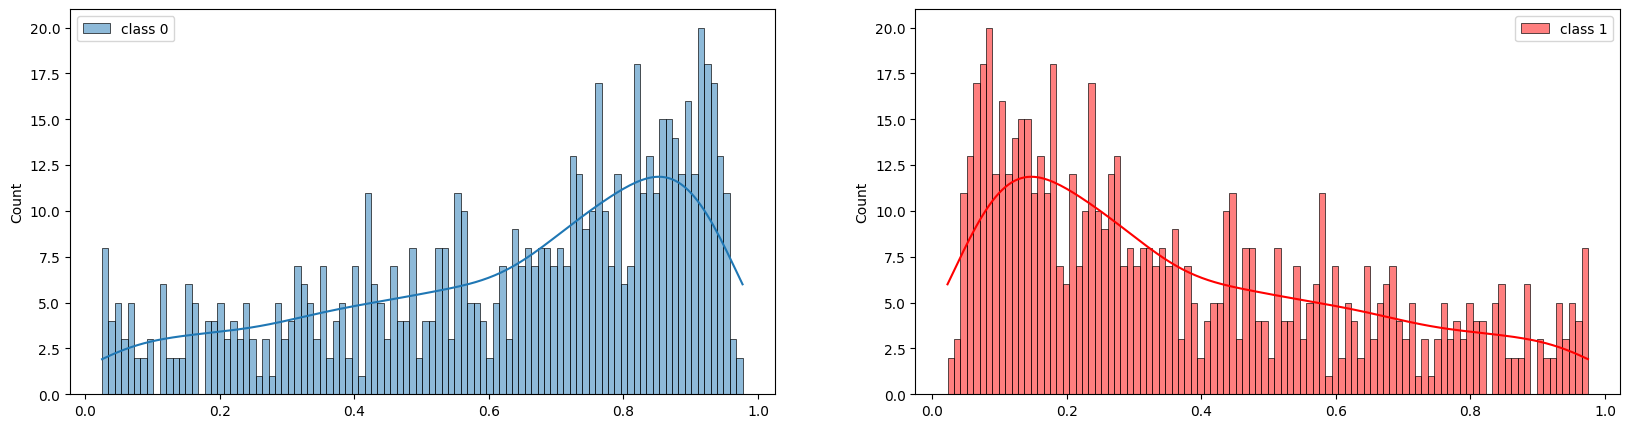

In [73]:
# y_pred_prob = model.predict_proba(X_test_scaled)
# probs_inverted = 1 - probs_scaled
# probs_normalized_1 = probs_inverted / np.max(probs_inverted)


plt.figure(figsize = (20, 5))
plt.subplot(121)
sns.histplot(prob[:, 0], bins = 100, label = 'class 0', kde = True)
plt.legend()
plt.subplot(122)
sns.histplot(prob[:, 1], bins = 100, color = 'red', label = 'class 1', kde = True)
plt.legend()
plt.show()


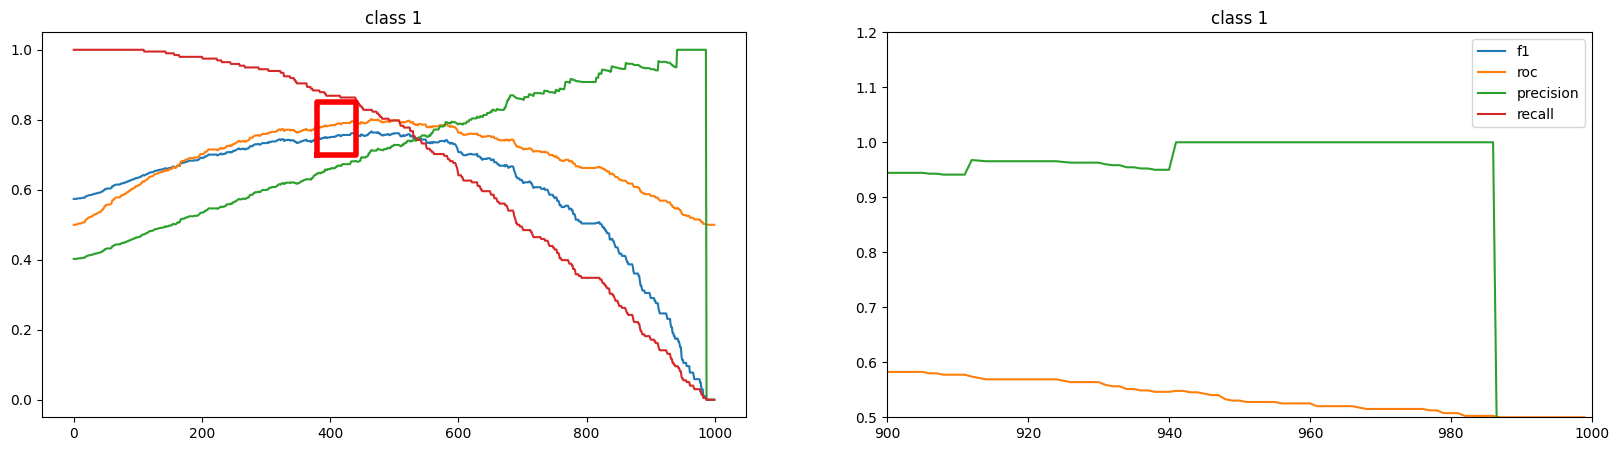

In [87]:
f1_1 = []
roc_1 = []
precision1 = []
recall1 = []

for i in np.linspace(0, 1, 1000):

    seuil = i

    y_pred_calibrated_1 = (y_pred_prob1 > i).astype("int32")

    f1_1.append(f1_score(y_test, y_pred_calibrated_1))
    roc_1.append(roc_auc_score(y_test, y_pred_calibrated_1))
    precision1.append(precision_score(y_test, y_pred_calibrated_1))
    recall1.append(recall_score(y_test, y_pred_calibrated_1))

plt.figure(figsize = (20, 5))

plt.subplot(121)
plt.plot(f1_1, label = 'f1')
plt.plot(roc_1, label = 'roc')
plt.plot(precision1, label = 'precision')
plt.plot(recall1, label = 'recall')
plt.plot([380, 380, 440, 440, 380], [0.7, 0.85, 0.85, 0.7, 0.7], c = 'red', linewidth = 4)
plt.title('class 1')


plt.subplot(122)
plt.plot(f1_1, label = 'f1')
plt.plot(roc_1, label = 'roc')
plt.plot(precision1, label = 'precision')
plt.plot(recall1, label = 'recall')
plt.title('class 1')
plt.xlim((900, 1000))
plt.ylim((0.5, 1.2))
plt.legend()

plt.show()

In [220]:
iso_reg_1 = IsotonicRegression(out_of_bounds='clip')
iso_reg_0 = IsotonicRegression(out_of_bounds='clip')

# Calibrer les probabilités pour la classe 1 et la classe 0
y_pred_prob_calibrated_1 = iso_reg_1.fit_transform(y_pred_prob[:, 1], y_test)  # Calibrer les probabilités pour la classe 1
y_pred_prob_calibrated_0 = iso_reg_0.fit_transform(y_pred_prob[:, 0], y_test)  # Calibrer les probabilités pour la classe 0

# Combiner les probabilités calibrées des deux classes
y_pred_prob_calibrated = np.column_stack((y_pred_prob_calibrated_0, y_pred_prob_calibrated_1))

# Étape 4: Utiliser un seuil pour faire les prédictions binaires
y_pred_calibrated_class = (y_pred_prob_calibrated[:, 1] > 0.41316).astype("int32")  # Prédictions pour la classe 1

# Évaluation des performances
print('score accuracy : ', model.score(X_test_scaled, y_test))
print('f1 score : ', f1_score(y_test, y_pred_calibrated_class))
print('roc-auc score : ', roc_auc_score(y_test, y_pred_calibrated_class))
print('brier score : ', brier_score_loss(y_test, y_pred_calibrated_class), '\n\n')

print(confusion_matrix(y_test, y_pred), '\n\n')
print(classification_report(y_test, y_pred))


score accuracy :  0.8853904282115869
f1 score :  0.764525993883792
roc-auc score :  0.85581329172922
brier score :  0.09697732997481108 


[[544  89]
 [ 21 140]] 


              precision    recall  f1-score   support

           0       0.96      0.86      0.91       633
           1       0.61      0.87      0.72       161

    accuracy                           0.86       794
   macro avg       0.79      0.86      0.81       794
weighted avg       0.89      0.86      0.87       794



In [58]:
f1_1 = []
roc_1 = []
precision1 = []
recall1 = []

for i in np.linspace(0, 1, 1000):

    seuil = i

    y_pred_calibrated_1 = (y_pred_prob_calibrated[:, 1] > i).astype("int32")

    f1_1.append(f1_score(y_test, y_pred_calibrated_1))
    roc_1.append(roc_auc_score(y_test, y_pred_calibrated_1))
    precision1.append(precision_score(y_test, y_pred_calibrated_1))
    recall1.append(recall_score(y_test, y_pred_calibrated_1))

NameError: name 'y_pred_prob_calibrated' is not defined

NameError: name 'f1_1' is not defined

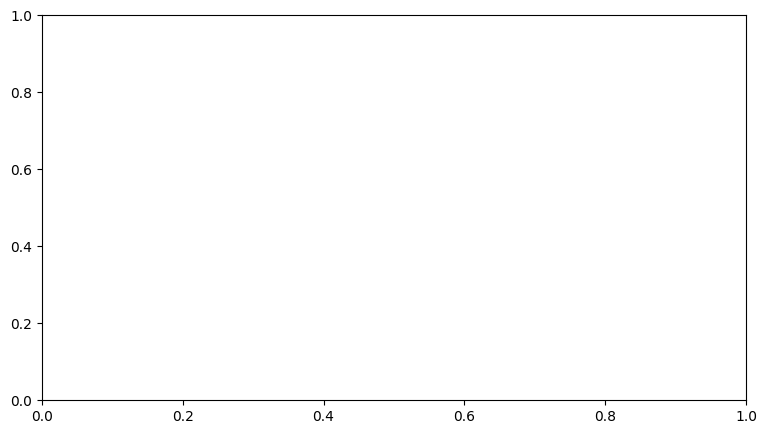

In [56]:
plt.figure(figsize = (20, 5))

plt.subplot(121)
plt.plot(f1_1, label = 'f1')
plt.plot(roc_1, label = 'roc')
plt.plot(precision1, label = 'precision')
plt.plot(recall1, label = 'recall')
plt.plot([380, 380, 440, 440, 380], [0.7, 0.85, 0.85, 0.7, 0.7], c = 'red', linewidth = 4)
plt.title('class 1')


plt.subplot(122)
plt.plot(f1_1, label = 'f1')
plt.plot(roc_1, label = 'roc')
plt.plot(precision1, label = 'precision')
plt.plot(recall1, label = 'recall')
plt.plot([413.16, 413.16], [0.725, 0.875], label = 'seuil d\'équilibre', linewidth = 2)
plt.title('class 1')
plt.xlim((413, 413.3))
plt.ylim((0.725, 0.875))
plt.legend()

plt.show()


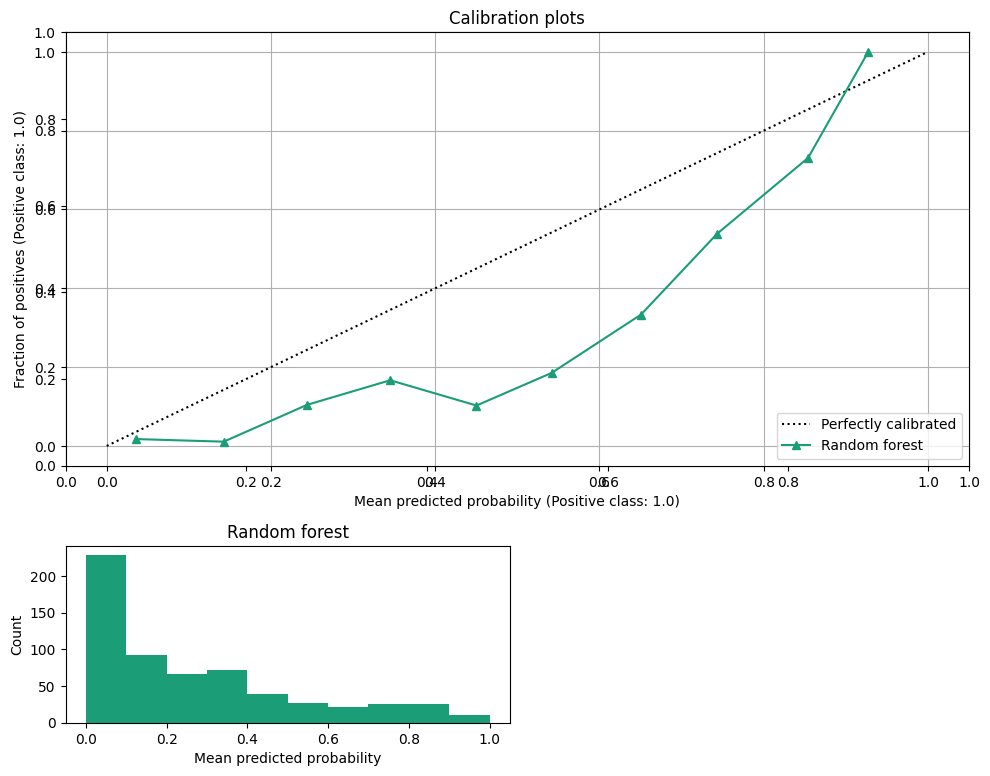

In [57]:
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}

clf_list = [
    (model, "Random forest"),
]

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
markers = ["^", "v", "s", "o"]
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    display = CalibrationDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
        marker=markers[i],
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()


In [ ]:
feature_importance = np.abs(coefficients)
sorted_indices = np.argsort(feature_importance)[::-1] # Trier les indices en fonction des poids, du plus grand au plus petit

# Afficher les features les plus importantes
print("Features triées par poids absolu :")
for idx in sorted_indices:
    print(f"{X.columns[idx]} : {coefficients[idx]}")

NameError: name 'coefficients' is not defined

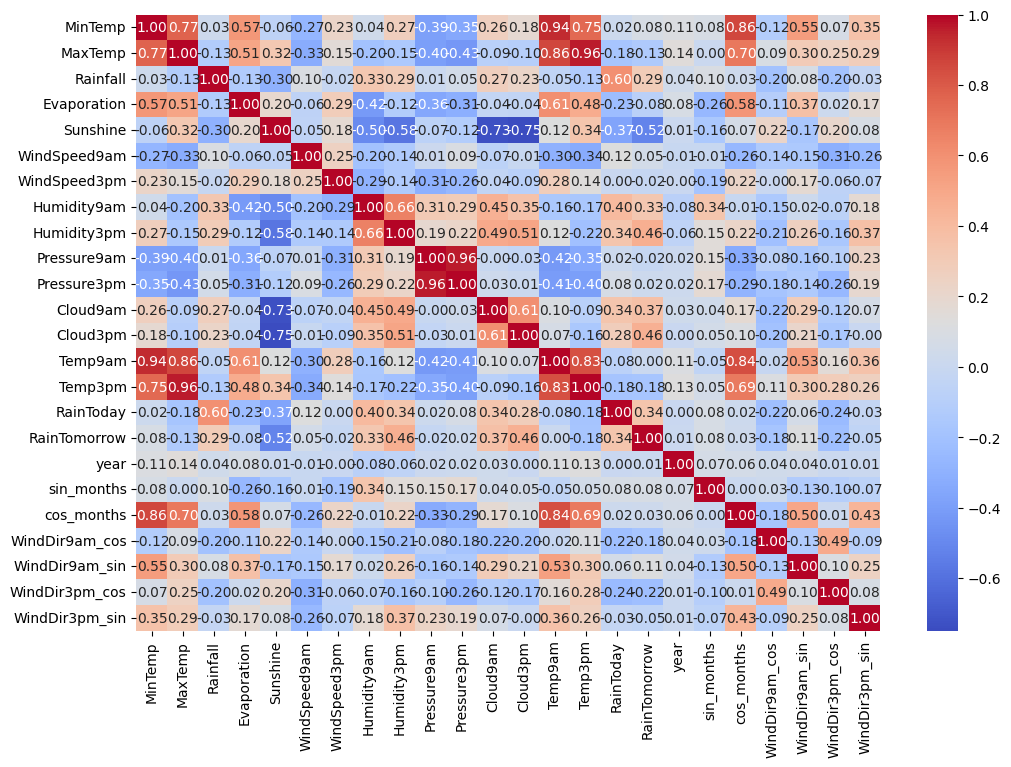

In [470]:
corr_matrix = df.corr()

# Visualiser la matrice de corrélation sous forme de heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

X = df.drop(columns='RainTomorrow')
y = df['RainTomorrow']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

# Mise à l'échelle des données
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Poids de la classe (pour compenser le déséquilibre)
poids = y_train.value_counts(normalize=True)
print(y_train.value_counts(normalize=True))
print(y_train.value_counts())

# Création du modèle
model = Sequential()

# Ajout de la première couche cachée
model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))

# Ajout d'une deuxième couche cachée
model.add(Dense(32, activation='relu'))

# Couche de sortie (classification binaire avec une activation sigmoïde)
model.add(Dense(1, activation='sigmoid'))

# Compilation du modèle
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Définition des callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

# Entraînement du modèle avec les callbacks
history = model.fit(X_train_scaled, y_train,
                    epochs=100,
                    batch_size=32,
                    verbose=1,
                    class_weight={0: 1/poids[0], 1: 1/poids[1]},
                    validation_data=(X_test_scaled, y_test),
                    callbacks=[reduce_lr])

# Évaluation du modèle sur les données de test
y_pred = (model.predict(X_test_scaled) > 0.5).astype("int32")  # Seuil de 0.5 pour classification binaire

# Affichage des résultats
print('score accuracy : ', model.evaluate(X_test_scaled, y_test)[1])
print('f1 score : ', f1_score(y_test, y_pred))
print('roc-auc score : ', roc_auc_score(y_test, y_pred))
print('brier score : ', brier_score_loss(y_test, y_pred), '\n\n')

# Matrice de confusion
print(confusion_matrix(y_test, y_pred), '\n\n')

RainTomorrow
0.0    0.737335
1.0    0.262665
Name: proportion, dtype: float64
RainTomorrow
0.0    1732
1.0     617
Name: count, dtype: int64
Epoch 1/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.6111 - loss: 1.1058 - val_accuracy: 0.8072 - val_loss: 0.3913 - learning_rate: 0.0010
Epoch 2/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8541 - loss: 0.6674 - val_accuracy: 0.8097 - val_loss: 0.3708 - learning_rate: 0.0010
Epoch 3/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8530 - loss: 0.6614 - val_accuracy: 0.8148 - val_loss: 0.3611 - learning_rate: 0.0010
Epoch 4/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8455 - loss: 0.6628 - val_accuracy: 0.8135 - val_loss: 0.3747 - learning_rate: 0.0010
Epoch 5/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8461 - loss: 0.6097 - val_accuracy: 0.8059 - val_loss: 0.3988 - learning_rate: 0.0010
Epoch 6/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8694 - loss: 0.5608 - val_accuracy: 0.

In [13]:
from tensorflow.keras.layers import SimpleRNN

X = df.drop(columns='RainTomorrow')
y = df['RainTomorrow']

# Mise à l'échelle des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshaping des données pour le RNN : (samples, time_steps, features)
# Ici, on assume que chaque "échantillon" est une série temporelle avec une seule "observation" à chaque étape de temps
# Pour simplifier, on suppose ici un seul time_step
X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Séparer les données en train et test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state=42, stratify=y)

# Poids de la classe (pour compenser le déséquilibre)
poids = y_train.value_counts(normalize=True)
print(y_train.value_counts(normalize=True))
print(y_train.value_counts())

# Création du modèle RNN
model = Sequential()

# Ajouter une couche RNN avec 64 unités
model.add(SimpleRNN(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))

# Couche de sortie (classification binaire avec une activation sigmoïde)
model.add(Dense(1, activation='sigmoid'))

# Compilation du modèle
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Définition des callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)

# Entraînement du modèle avec les callbacks
history = model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=32,
                    verbose=1,
                    class_weight={0: 1/poids[0], 1: 1/poids[1]},
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping, reduce_lr])

# Évaluation du modèle sur les données de test
y_pred = (model.predict(X_test) > 0.5).astype("int32")  # Seuil de 0.5 pour classification binaire

# Affichage des résultats
print('score accuracy : ', model.evaluate(X_test, y_test)[1])
print('f1 score : ', f1_score(y_test, y_pred))
print('roc-auc score : ', roc_auc_score(y_test, y_pred))
print('brier score : ', brier_score_loss(y_test, y_pred), '\n\n')

# Matrice de confusion
print(confusion_matrix(y_test, y_pred), '\n\n')

RainTomorrow
0.0    0.737335
1.0    0.262665
Name: proportion, dtype: float64
RainTomorrow
0.0    1732
1.0     617
Name: count, dtype: int64


ValueError: Input 0 of layer "simple_rnn_3" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 64)